#Imports


In [1]:
# Main Libraries
import tensorflow as tf
import keras
# Load Dataset Functions and Data Augmentation Functions
from keras.utils import image_dataset_from_directory
from tensorflow import image as augment
# Plotting Image
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import os
# Layers, Metrics and Optimizers Functions
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Flatten
from keras.metrics import F1Score, CategoricalAccuracy
from keras.optimizers import Adam
# Models and Applications Functions
from keras.models import Model
from keras.applications import MobileNetV3Large
from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import EfficientNetV2B3
# Every Application Preprocessing Functions
from keras.applications.mobilenet_v3 import preprocess_input as mobilepre
from keras.applications.resnet50 import preprocess_input as resnetpre
from keras.applications.inception_v3 import preprocess_input as inceptionpre
from keras.applications.efficientnet_v2 import preprocess_input as efficientnetpre


#Dataset


## Downloading Dataset

In [3]:
!gdown 1O4YR4UBatOLnaP4gMHbmFw7UJvhhxFwq
!gdown 1-7aMdKW4KcCKLwoUKC3XxdIwfIKkzwx6

Downloading...
From: https://drive.google.com/uc?id=1O4YR4UBatOLnaP4gMHbmFw7UJvhhxFwq
To: /content/train_data.zip
100% 173M/173M [00:01<00:00, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-7aMdKW4KcCKLwoUKC3XxdIwfIKkzwx6
To: /content/test_data.zip
100% 73.0M/73.0M [00:01<00:00, 47.6MB/s]


## Unzipping dataset


In [ ]:
!unzip 'test_data.zip'
!unzip 'train_data.zip'

## Loading Dataset

### Train Dataset

In [5]:
dir = 'train_data'

In [37]:
train_dataset = image_dataset_from_directory(dir, validation_split=0.05, seed=42, image_size=(456, 456), subset = 'training', batch_size=16)
type(train_dataset)

Found 9990 files belonging to 10 classes.
Using 9491 files for training.


tensorflow.python.data.ops.prefetch_op._PrefetchDataset

### Validation Dataset

In [38]:
validation_dataset = image_dataset_from_directory(dir, validation_split=0.05, seed=42, image_size=(456, 456), subset='validation', batch_size=16)
type(validation_dataset)

Found 9990 files belonging to 10 classes.
Using 499 files for validation.


tensorflow.python.data.ops.prefetch_op._PrefetchDataset

## Plotting Images
Using matplotlib, os and pathlib to plot 5 random images from each class in ten rows and five columns which is totally 50 images.

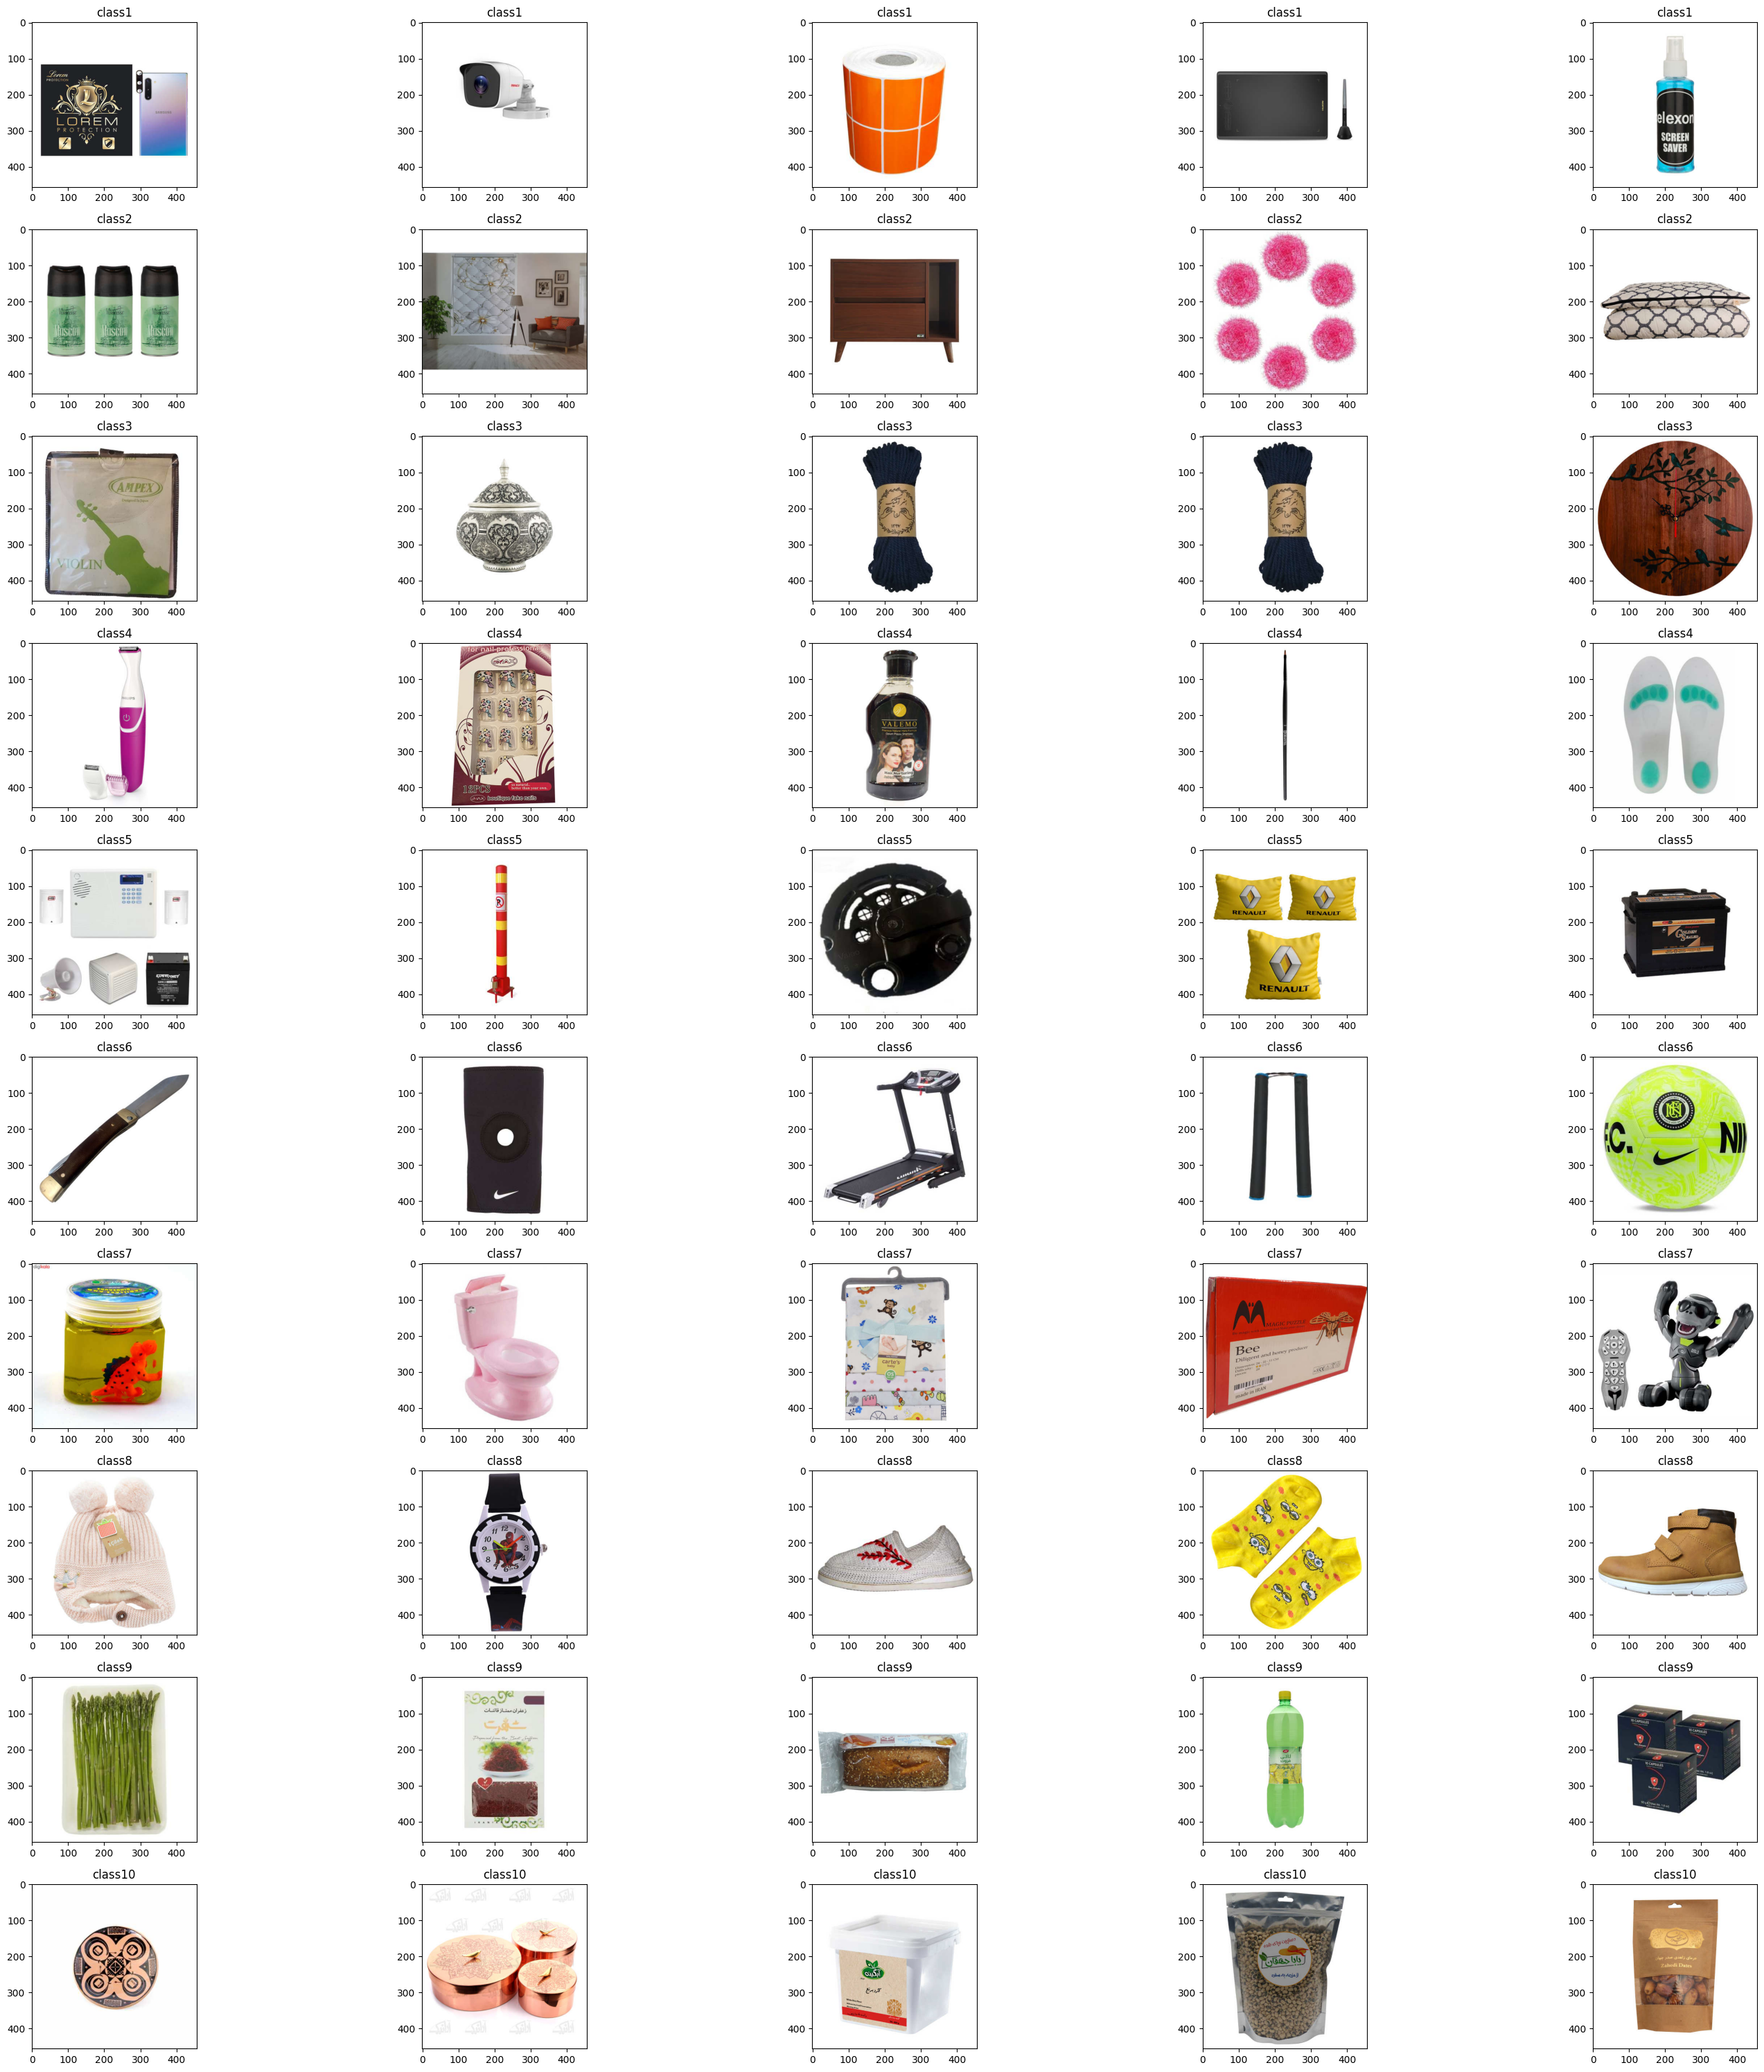

In [25]:
root_path = pathlib.Path('train_data')
fig, ax = plt.subplots(nrows=10, ncols=5 , figsize=(30, 30))
for i in range(1, 11):
  current_class_dir = root_path / f'{i}'
  files = os.listdir(current_class_dir)
  for j in range(5):
    random_images = os.path.join(current_class_dir, random.choice(files))
    img = mpimg.imread(random_images)
    ax[i-1][j].imshow(img)
    ax[i-1][j].set_title(f'class{i}')

plt.tight_layout()

#Data Augmentation
Here we augment data and changing labels to one hot.

In [39]:
def DataAugmentation(image , label):
  image = augment.random_flip_left_right(image)
  image = augment.random_flip_up_down(image)
  image = augment.rot90(image, k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
  image = augment.random_brightness(image, max_delta=0.2)
  image = augment.random_contrast(image, lower=0.7, upper=1.3)
  image = augment.random_saturation(image, lower=0.7, upper=1.3)
  image = augment.random_hue(image, max_delta=0.3)

  return image , label

train_dataset = train_dataset.map(DataAugmentation, num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(lambda x, y: (x, tf.one_hot(y, 10)))
validation_dataset = validation_dataset.map(lambda x, y: (x, tf.one_hot(y, 10)))

#Training Models


In [27]:
num_classes = 10

In [28]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

##MobileNetV3Large



### Preprocessing , Setting Layers and Compiling Custom Model


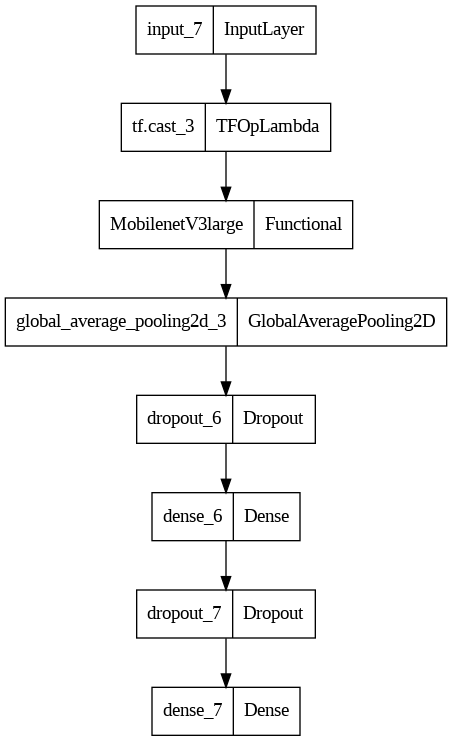

In [41]:
input_layer = Input([456, 456, 3])
x = tf.cast(input_layer , dtype = tf.float32)
x = mobilepre(x)

mobilenet_model = MobileNetV3Large(weights='imagenet',
                                   include_top=False)(x)

output_layer = GlobalAveragePooling2D()(mobilenet_model)
output_layer = Dropout(0.4)(output_layer)
output_layer = Dense(1024,  activation='relu')(output_layer)
output_layer = Dropout(0.2)(output_layer)
output_layer = Dense(num_classes, activation='softmax')(output_layer)

mobilenet_custom_model = Model(inputs=input_layer,
                               outputs=output_layer)

mobilenet_custom_model.compile(optimizer=Adam(0.0001),
                               loss='categorical_crossentropy',
                               metrics=[F1Score(average='micro'), CategoricalAccuracy()])
keras.utils.plot_model(mobilenet_custom_model)

### Fitting Model

In [42]:
checkpoint_path = "/content/drive/MyDrive/Data/quera/mobile_net_v3_large_model_checkpoints/mbnv3l.ckpt"

In [43]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_categorical_accuracy", # save the model weights with best validation
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=1)

In [44]:
mobilenet_custom_model.load_weights(checkpoint_path)

In [ ]:
history_mobilenet_v3_large = mobilenet_custom_model.fit(train_dataset,
                                                        validation_data=validation_dataset,
                                                        epochs=10,
                                                        callbacks=[create_tensorboard_callback("/content/drive/MyDrive/Data/quera/training_logs",
                                                                                               "mobilenet_v3_large"),
                                                                                               model_checkpoint])


In [53]:
mobilenet_custom_model.evaluate(validation_dataset)

32/32 [==============================] - 4s 99ms/step - loss: 2.3635 - f1_score: 0.6573 - categorical_accuracy: 0.6573


[2.3634705543518066, 0.657314658164978, 0.657314658164978]

## ResNet50

### Preprocessing , Setting Layers and Compiling Custom Model

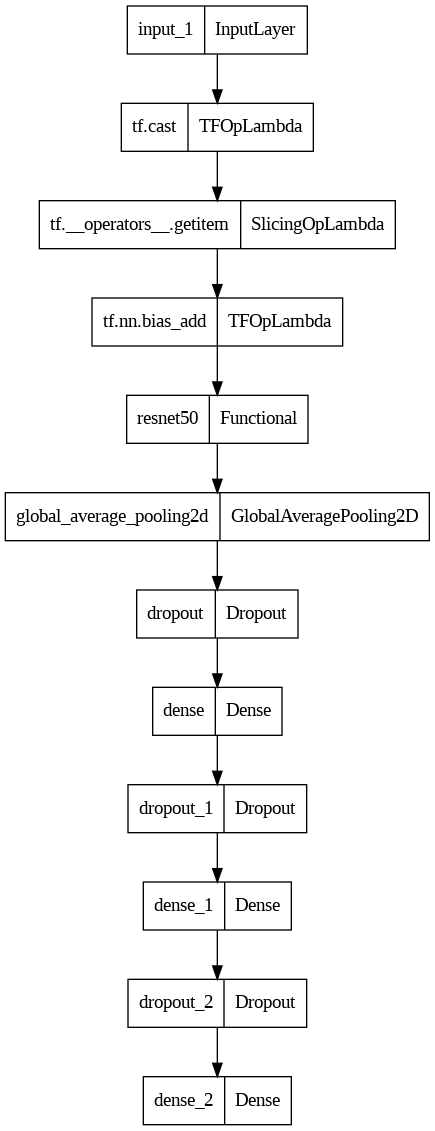

In [ ]:
input_layer = Input([456, 456, 3])
x = tf.cast(input_layer , dtype = tf.float32)
x = resnetpre(x)

resnet_model = ResNet50(weights='imagenet', include_top=False)(x)

output_layer = GlobalAveragePooling2D()(resnet_model)
output_layer = Dropout(0.4)(output_layer)
output_layer = Dense(256, activation=('relu'))(output_layer)
output_layer = Dropout(0.3)(output_layer)
output_layer = Dense(128, activation=('relu'))(output_layer)
output_layer = Dropout(0.2)(output_layer)
output_layer = Dense(num_classes, activation='softmax')(output_layer)

resnet_custom_model = Model(inputs = input_layer , outputs = output_layer)
resnet_custom_model.compile(optimizer = Adam(0.0001), loss = 'categorical_crossentropy', metrics = [F1Score(average = 'micro')])
keras.utils.plot_model(resnet_custom_model)

### Fitting Model

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Data/quera/resnet_50_model_checkpoints/resnet_50.ckpt"

In [ ]:
# resnet_custom_model.load_weights(checkpoint_path)

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_f1_score", # save the model weights with best validation
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved


resnet_history = resnet_custom_model.fit(train_dataset,
                                         validation_data=validation_dataset,
                                         epochs=100,
                                         callbacks=[create_tensorboard_callback("training_logs",
                                                                                "resnet_50"),
                                                                                model_checkpoint])

In [ ]:
resnet_custom_model.evaluate(validation_dataset)

63/63 [==============================] - 13s 205ms/step - loss: 1.8154 - f1_score: 0.4014


[1.815439224243164, 0.4014014005661011]

## Predicting Test Dataset

In [59]:
def load_and_prep_image(filename, img_shape=456):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  return img

In [63]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img/255)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [86]:
def pred(model, filename, class_names):
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred.argmax()]
  return pred_class

In [85]:
import pandas as pd

y_preds = pd.DataFrame({'name': [], 'predicted': []})

In [ ]:
import os

class_names=[1, 10, 2, 3, 4, 5, 6, 7, 8, 9]

for img in os.listdir('/content/test_data/'):
  print(img)
  y_pred = pred(mobilenet_custom_model, f'/content/test_data/{img}', class_names)
  y_preds = pd.concat([y_preds, pd.DataFrame({'name': [f'{img}'], 'predicted': [y_pred]})], ignore_index = True)


In [92]:
y_preds.to_csv('q1_submission.csv', index=False)

1/1 [==============================] - 0s 101ms/step


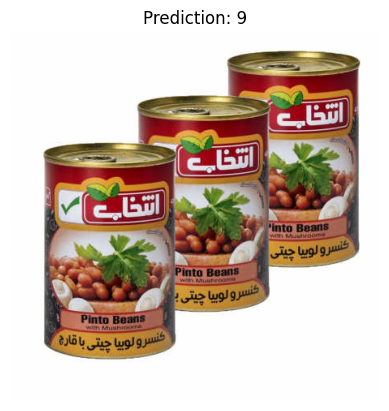

In [71]:
pred_and_plot(mobilenet_custom_model, "/content/test_data/1db46be4a177795d9ca78c255aca4ce19664a94f_1628516922.jpg", class_names)
# load_and_prep_image('/content/test_data/0009e12a0edb16b231b73e501366209662a51363_1614099213.jpg')